In [45]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import imageio
import numpy as np
import h5py
import random
import tensorflow.keras as keras

In [ ]:
# multiple inputs https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [3]:
colours = np.array([
    [199,191,193,128],  
    [0,0,0,0],
    [  0,   0, 254, 255],
    [ 50, 101, 254, 255],
    [127, 127,   0, 255],
    [254, 203,   0, 255],
    [254, 152,   0, 255],
    [254,   0,   0, 255],
    [254,   0, 254, 255],
    [229, 254, 254, 255]
])

In [4]:
train_df = pd.read_csv('train.csv')
train_df['timestamp'] = pd.to_datetime(train_df['Unnamed: 0'])
train_df = train_df.set_index('timestamp')
train_df = train_df[['level']]

In [5]:
f = h5py.File('images.h5','r')
train_images = f['train'][:]
f.close()

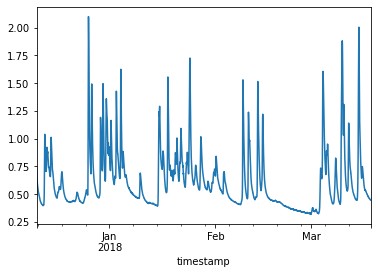

In [6]:
train_df.level.plot()
plt.show()

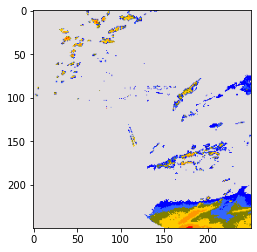

In [11]:
plt.imshow(colours[train_images[25,:,:]])

In [8]:
raw_X = train_images.reshape(((9404, 250*250)))
raw_Y = train_df.level.values

print(raw_X.shape)
print(raw_Y.shape)

(9404, 62500)
(9404,)


In [21]:
parameters = {
    "batch_size": 100,
    "num_level_updates": 24*4,
    "num_steps": 60
}


def sample_generator(raw_X, raw_Y, num_level_updates, num_steps, rain_threshold):
    while True: # TODO might need to halt this?
        i = random.randint(0, raw_X.shape[0] - num_steps)
        x = raw_X[i: i+num_steps]

        # This means we get fewer samples with no rain
        if np.sum(x) < rain_threshold:
            if random.randint(0, 10) > 4:
                continue


        y = raw_Y[i: i+num_steps]
        #update_vector = np.zeros(num_steps)
        #update_vector[0:num_level_updates] = 1
        # FOR NOW DON'T INCLUDE OLD LEVEL UPDATES
        #x = np.column_stack([x, update_vector, update_vector*y])
        y = np.column_stack([y])

        x = np.array(x)
        y = np.array(y)
        yield (x, y)
        
        

In [34]:

batch_size = parameters["batch_size"]
num_level_updates = parameters["num_level_updates"]
num_steps = parameters["num_steps"]
rain_threshold=0
#sample_generator_specific = sample_generator(raw_X, raw_Y, num_level_updates, num_steps, rain_threshold=0)

dataset = tf.data.Dataset.from_generator(
     sample_generator,
     (tf.uint8, tf.float64),
    output_shapes=(tf.TensorShape((None, None)), tf.TensorShape((None, 1))),
    args = [raw_X, raw_Y, num_level_updates, num_steps, rain_threshold]
)



In [35]:
data= list(dataset.take(3).as_numpy_iterator())

In [43]:
model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128, return_sequences=True))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 10)          1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer=keras.optimizers.Adagrad(),
              # Loss function to minimize
              loss=keras.losses.MeanSquaredError()
              # List of metrics to monitor
              #metrics=['sparse_categorical_accuracy']
             )

In [52]:
history = model.fit(dataset,
                    epochs=3, steps_per_epoch=20)

print('\nhistory dict:', history.history)

ValueError: in converted code:

    /Users/jconn/isthedartrunning/analysis/ENV_ANALYSIS/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /Users/jconn/isthedartrunning/analysis/ENV_ANALYSIS/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /Users/jconn/isthedartrunning/analysis/ENV_ANALYSIS/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:526 standardize_input_data
        standardize_single_array(x, shape) for (x, shape) in zip(data, shapes)
    /Users/jconn/isthedartrunning/analysis/ENV_ANALYSIS/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:526 <listcomp>
        standardize_single_array(x, shape) for (x, shape) in zip(data, shapes)
    /Users/jconn/isthedartrunning/analysis/ENV_ANALYSIS/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:451 standardize_single_array
        if (x.shape is not None and len(x.shape) == 1 and
    /Users/jconn/isthedartrunning/analysis/ENV_ANALYSIS/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_shape.py:822 __len__
        raise ValueError("Cannot take the length of shape with unknown rank.")

    ValueError: Cannot take the length of shape with unknown rank.


In [ ]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)